# 과제2

## 이선우(20223888)

## Condition

$\$300000$ European Call Option > 100,000 shares of stock

$S_0 = 49$ <br>
$K = 50$ <br>
$r = 5\%$ <br>
$\sigma = 20\%$ <br>
$T = 20 weeks$ <br>
$\mu = 13\%$

## Code

In [313]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm
from warnings import filterwarnings
filterwarnings('ignore')

In [328]:
from scipy.stats import skewnorm as sn

sn.stats(10)

(array(0.79392481), array(0.36968339))

In [314]:
from scipy.stats import skewnorm as sn
class delta_hedging:

    def __init__(self, input):
 
        self.s0         = input['s0']               # 현재가격
        self.k          = input['k']                # 행사가격
        self.rf         = input['rf']               # 무위험이자율
        self.sigma      = input['sigma']            # 변동성
        self.mu         = input['mu']               # 평균수익률
        self.T          = input['T']                # 투자기간
        self.q          = input['q']                # 배당금 
        self.iv         = input['imvol']            # 내재변동성

        self.interval   = input['interval']         # T의 기간 텀
        self.time_step  = input['time_step']        # Investment Horizon
        self.simul      = input['simul_num']        # 시뮬레이션 횟수
        self.num_shares = input['num_shares']       # 종목 수

        if self.interval == 'weekly':               
            self.dt = self.T / 52                   
        elif self.interval == 'daily':
            self.dt = self.T / 255
        
        self.tau        = self.time_step * self.dt
        self.tau_arr    = (np.flip(np.arange(0, self.time_step+1)) * self.dt).reshape(-1,1)

    def bs_call(self, PutCall):
        '''PutCall for 'c', 'p' '''
        d1 = (np.log(self.s0/self.k) +((self.rf - self.q +0.5*np.power(self.sigma, 2))*self.tau))/(self.sigma*np.sqrt(self.tau))
        d2 = d1 - self.sigma*np.sqrt(self.tau)
        value = self.s0*norm.cdf(d1) - self.k*np.exp(-self.rf*self.tau)*norm.cdf(d2)
        return value

    def stock_path(self):

        value = np.ones((2, self.simul)) * self.s0

        for idx in range(1, self.T * self.time_step + 1):
            d_term = (self.mu - self.q - 0.5 * self.sigma**2) * self.dt
            #s_term = self.sigma * np.sqrt(self.dt) * np.random.normal(size=(self.simul))


            sn
            s_term = self.sigma * np.sqrt(self.dt) * np.random.normal(size=(self.simul))

            value = np.vstack([value, value[-1] * np.exp(d_term + s_term)])
            
        value = value[1:]

        return value


    def d1_cal (self, s, k, r, q, vol, t):
        return (np.log(s/k) +((r-q+0.5*np.power(vol, 2))*t))/(vol*np.sqrt(t))

    def path_delta(self, stock_path=None):
        
        if stock_path is not None:
            path = stock_path
        else:
            path = self.stock_path()

        delta = norm.cdf(self.d1_cal(path, self.k, self.rf, self.q, self.iv, self.tau_arr))
        
        return delta

    def path_changes (self, path_1):
        '''calculate path's changes'''

        return np.vstack([path_1[0], path_1[1:] - path_1[:-1]])
        

    def path_delta_shares(self, stock_path=None):
        '''input stock path (stock price path)'''

        if stock_path is not None:
            path = self.path_delta(stock_path)
        else:
            stock_path = self.stock_path()
            path = self.path_delta(stock_path)
        
        return path * self.num_shares

    def path_delta_shares_cost (self, stock_path=None):
        '''input stock path (stock price path)'''

        if stock_path is not None:
            path = self.path_delta_shares(stock_path)
        else:
            stock_path = self.stock_path()
            path = self.path_delta_shares(stock_path)

        return path * stock_path

    def path_delta_hedged_cum (self, stock_path=None):

        if stock_path is not None:
            path = self.path_delta_shares_cost(stock_path)

        else:
            stock_path = self.stock_path()
            path = self.path_delta_shares_cost(stock_path)

        path_cost_ch = self.path_changes(path)

        delta_path_cumcost = np.repeat(path_cost_ch[0], stock_path.shape[0]).reshape(-1, stock_path.shape[1])
        upper = (1 + self.rf*1/52)

        for x in range(0, stock_path.shape[1]):
            for idx in range(stock_path[:,x].shape[0]-1):
                delta_path_cumcost[idx+1, x] = np.round(delta_path_cumcost[idx,x] * upper + path_cost_ch[idx+1, x])

        return delta_path_cumcost

    def delta_hedging_int_cost (self, stock_path=None):

        if stock_path is not None:
            path = self.path_delta_hedged_cum(stock_path)
        else:
            stock_path = self.stock_path()
            path = self.path_delta_hedged_cum(stock_path)

        return path * (self.dt * self.rf)

    def hedging_cost(self, stock_path=None):

        if stock_path is not None:
            delta = self.path_delta(stock_path)
        else:
            stock_path = self.stock_path()
            delta = self.path_delta(stock_path)

        path_arr = np.vstack([delta[0], (delta[1:] - delta[:-1])])
        
        hedge_arr = ((path_arr * stock_path) * np.exp(self.rf * self.tau_arr)).cumsum(axis=0)[-1]
        hedge_arr = np.where(hedge_arr > self.k, hedge_arr - self.k, hedge_arr)

        return hedge_arr

    def hedge_PNL(self, stock_path=None):

        if stock_path is not None:
            int_cost = self.delta_hedging_int_cost(stock_path)
            cum_cost = self.path_delta_hedged_cum(stock_path)

        else:
            stock_path = self.stock_path()
            int_cost = self.delta_hedging_int_cost(stock_path)
            cum_cost = self.path_delta_hedged_cum(stock_path)
        



In [315]:
dt = delta_hedging(inputs)

In [326]:
dt.hedging_cost().mean()

2.437462240993996

## 이자비용이랑 cum cost 랑 활용해서 K 이용해서 뺀거 구하기

In [202]:
dt.path_delta_hedged_cum(path).shape, dt.delta_hedging_int_cost(path).shape

((21, 1000), (21, 1000))

In [277]:
np.exp(-dt.rf * dt.time_step) 

0.36787944117144233

In [312]:
path = dt.stock_path()
arr = np.c_[(dt.delta_hedging_int_cost(path).sum(axis=0) + dt.path_delta_hedged_cum(path)[-1]), path[-1]]
np.exp(-dt.rf * dt.time_step) * (np.where(arr[:,1]>= dt.k, arr[:,0] - dt.k * dt.num_shares, arr[:,0])).mean()

171217.64297898766

In [216]:
dt.k * dt.num_shares

5000000

In [248]:
(np.where(arr[:,1]>= dt.k, arr[:,0] - dt.k * dt.num_shares, arr[:,0])).mean()

450585.9668992552

In [239]:
(dt.hedging_cost() * dt.num_shares).mean()

243890.42059138202

In [193]:
pd.DataFrame([dt.hedging_cost(path), path[-1]]).T

,0,1
0,2.939264,58.036163
1,2.567156,42.757299
2,2.579886,53.964753
3,2.270073,54.625356
4,2.445431,49.879434
...,...,...
995,2.529085,41.125228
996,2.437486,56.731933
997,2.486854,49.672310
998,3.174027,51.158697


In [ ]:
hedging_cost(path)

In [184]:
'''Parameters'''
inputs = {
    's0' : 49,
    'k' : 50,
    'rf' : 0.05,
    'sigma' : 0.2,
    'imvol' : 0.2,
    'T' : 1,
    'mu' : 0.13,
    'q' : 0,
    'interval' : 'weekly',
    'time_step' : 20,
    'simul_num' : 1000,
    'num_shares' : 100000
}

In [185]:
dt = delta_hedging(inputs)

In [186]:
path = dt.stock_path()
path

array([[49.        , 49.        , 49.        , ..., 49.        ,
        49.        , 49.        ],
       [51.27704325, 49.28095414, 51.8607462 , ..., 49.98323189,
        50.23783401, 46.21014462],
       [48.59401232, 46.965551  , 50.05704968, ..., 53.08223869,
        47.58922577, 46.53702934],
       ...,
       [58.59147547, 41.88005782, 54.75804858, ..., 48.49258926,
        51.95254251, 47.71817078],
       [57.07807341, 41.3519334 , 54.27724778, ..., 51.08548897,
        52.28481861, 46.70925764],
       [58.03616285, 42.75729855, 53.9647535 , ..., 49.67231033,
        51.15869678, 46.57022977]])

In [188]:
dt.path_delta_shares(path)

array([[5.21604661e+04, 5.21604661e+04, 5.21604661e+04, ...,
        5.21604661e+04, 5.21604661e+04, 5.21604661e+04],
       [6.62822368e+04, 5.36550233e+04, 6.96306097e+04, ...,
        5.82693990e+04, 5.99022295e+04, 3.29808846e+04],
       [4.85452096e+04, 3.72155775e+04, 5.85355288e+04, ...,
        7.62475726e+04, 4.15258491e+04, 3.43089614e+04],
       ...,
       [9.99980328e+04, 4.30496097e-01, 9.91487784e+04, ...,
        2.38289443e+04, 8.52057365e+04, 1.30877175e+04],
       [9.99999290e+04, 5.28410063e-07, 9.98685348e+04, ...,
        7.94722618e+04, 9.51503179e+04, 8.06092023e+02],
       [1.00000000e+05, 0.00000000e+00, 1.00000000e+05, ...,
        0.00000000e+00, 1.00000000e+05, 0.00000000e+00]])

In [27]:
dt.path_delta_shares_cost(path)

array([[2.55586284e+06, 2.55586284e+06, 2.55586284e+06, ...,
        2.55586284e+06, 2.55586284e+06, 2.55586284e+06],
       [3.88048652e+06, 2.34724303e+06, 2.99858952e+06, ...,
        2.40870183e+06, 2.30989590e+06, 1.82297476e+06],
       [4.70369209e+06, 2.32001862e+06, 2.85695288e+06, ...,
        3.01608147e+06, 1.81384654e+06, 1.75972473e+06],
       ...,
       [5.30443940e+06, 9.19548874e+02, 1.20358912e+06, ...,
        1.38563900e+05, 4.90504334e+06, 4.20855184e+02],
       [5.43987668e+06, 4.67497168e-02, 2.06648871e+06, ...,
        3.72111963e+02, 5.10823704e+06, 2.69825707e-03],
       [5.32520719e+06, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 5.45308291e+06, 0.00000000e+00]])

In [28]:
np.round((dt.path_delta_hedged_cum(path) / 1000),1)

array([[2555.9, 2555.9, 2555.9, ..., 2555.9, 2555.9, 2555.9],
       [3882.9, 2349.7, 3001. , ..., 2411.2, 2312.4, 1825.4],
       [4709.9, 2324.7, 2862.3, ..., 3020.9, 1818.5, 1763.9],
       ...,
       [5386.1,   26.1, 1271.3, ...,  203.1, 4932.2,   18.9],
       [5526.7,   25.2, 2135.4, ...,   65.1, 5140.2,   18.5],
       [5417.3,   25.2,   71. , ...,   64.8, 5490. ,   18.6]])

In [167]:
np.round((dt.delta_hedging_int_cost(path) / 1000),1)

array([[2.5, 2.5, 2.5, ..., 2.5, 2.5, 2.5],
       [3.7, 2.3, 2.9, ..., 2.3, 2.2, 1.8],
       [4.5, 2.2, 2.8, ..., 2.9, 1.7, 1.7],
       ...,
       [5.2, 0. , 1.2, ..., 0.2, 4.7, 0. ],
       [5.3, 0. , 2.1, ..., 0.1, 4.9, 0. ],
       [5.2, 0. , 0.1, ..., 0.1, 5.3, 0. ]])

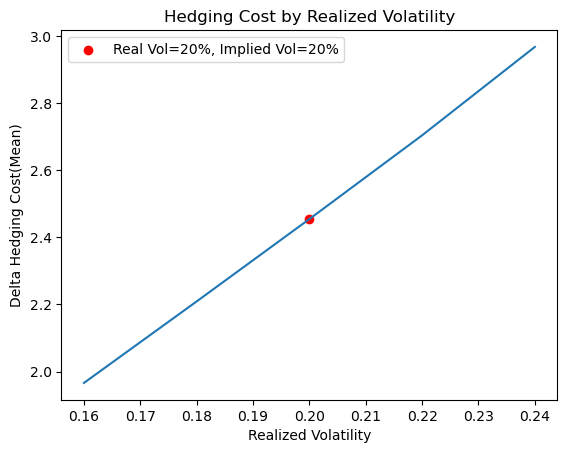

In [4]:
rv_arr = np.array([0.16, 0.18, 0.20, 0.22, 0.24])

stock_path_data = []
delta_path_data = []
dt_hedging_data = []
dt_hedging_cost = []
dt_hedging_cost_mean = []
dt_hedging_cost_std = []

for rv in rv_arr:
    inputs['sigma'] = rv

    stock_path_data.append(delta_hedging(inputs).stock_path())
    delta_path_data.append(delta_hedging(inputs).path_delta())
    dt_hedging_data.append(delta_hedging(inputs).hedging_cost())
    dt_hedging_cost_mean.append(delta_hedging(inputs).hedging_cost().mean())
    dt_hedging_cost_std.append(delta_hedging(inputs).hedging_cost().std())
    
df = pd.DataFrame(data=[stock_path_data, delta_path_data, dt_hedging_data, dt_hedging_cost_mean, dt_hedging_cost_std],\
                  index=['stock_path_data', 'delta_path_data', 'dt_hedging_data', 'mean', 'std'],\
                  columns=rv_arr).T

plt.title('Hedging Cost by Realized Volatility')
plt.scatter(0.2, df.loc[0.2]['mean'], c='r', label='Real Vol=20%, Implied Vol=20%')
plt.plot(df['mean'])
plt.xlabel('Realized Volatility')
plt.ylabel('Delta Hedging Cost(Mean)')
plt.legend()
plt.show()

100%|██████████| 1000/1000 [00:06<00:00, 156.45it/s]


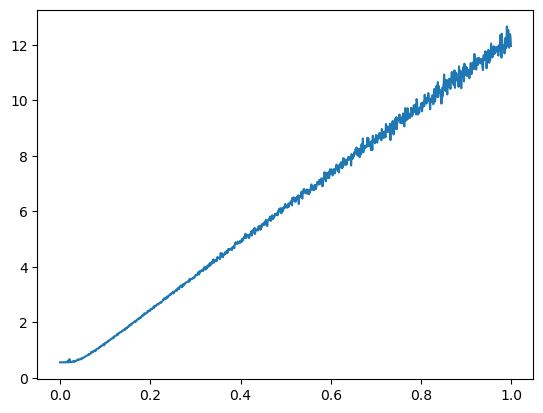

In [5]:
from tqdm import tqdm

rv_arr = np.arange(0, 1, 0.001)

stock_path_data = []
delta_path_data = []
dt_hedging_data = []
dt_hedging_cost = []
dt_hedging_cost_mean = []
dt_hedging_cost_std = []

for rv in tqdm(rv_arr):
    inputs['sigma'] = rv

    stock_path_data.append(delta_hedging(inputs).stock_path())
    delta_path_data.append(delta_hedging(inputs).path_delta())
    dt_hedging_data.append(delta_hedging(inputs).hedging_cost())
    dt_hedging_cost_mean.append(delta_hedging(inputs).hedging_cost().mean())
    dt_hedging_cost_std.append(delta_hedging(inputs).hedging_cost().std())
    
df = pd.DataFrame(data=[stock_path_data, delta_path_data, dt_hedging_data, dt_hedging_cost_mean, dt_hedging_cost_std],\
                  index=['stock_path_data', 'delta_path_data', 'dt_hedging_data', 'mean', 'std'],\
                  columns=rv_arr).T

plt.plot(df['mean'])
plt.show()